In [12]:
import os
import csv
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
import random
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
import math
import multiprocessing
import time

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from torchvision import datasets

In [15]:
DATA_PATH = os.path.join('./noodles_dataset_3k/')
print(os.listdir(DATA_PATH))

# use gpu if you have
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print ("MPS device is available. Successfully initiated:")
    print (x)
    device = mps_device
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU is available.")
    print("GPU device count:", torch.cuda.device_count())
    print("Current GPU device:", torch.cuda.current_device())
    print("GPU device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    device = torch.device("cpu")

print("Use device:",device)

# set random seed
SEED = int(time.time())
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
multiprocessing.set_start_method("fork")

['test', 'train']
GPU is available.
GPU device count: 1
Current GPU device: 0
GPU device name: NVIDIA GeForce RTX 3060
Use device: cuda:0


RuntimeError: context has already been set

In [16]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(0.485, 0.229)
    ])
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(0.485, 0.229)
    ])

In [17]:
# Specify the path to the training folder.
TRAINDATA_PATH = os.path.join('.','noodles_dataset_3k','train')
# print(TRAINDATA_PATH)
label_name = {"0_spaghetti": 0, "1_ramen": 1, "2_udon": 2}

def get_img_info(data_dir):
        imgpath = []
        imglabel = []
        for root, dirs, _ in os.walk(data_dir):
            # print("root: ", root)
            # print("dirs: ", dirs)
            # Traverse categories
            for sub_dir in dirs:
                img_names = os.listdir(os.path.join(root, sub_dir))
                img_names = list(filter(lambda x: x.endswith('.jpg'), img_names))

                # Traverse images
                for i in range(len(img_names)):
                    img_name = img_names[i]
                    path_img = os.path.join(root, sub_dir, img_name)
                    label = label_name[sub_dir]
                    imgpath.append(path_img)
                    imglabel.append(int(label))

        # Return image paths and labels in data_info
        return imgpath,  imglabel

imgpath,  imglabel = get_img_info(TRAINDATA_PATH)

In [18]:
class Custom_dataset(Dataset):
    def __init__(self,trainData,trainLabel,transform=None):
        # --------------------------------------------
        # Initialize paths, transforms, and so on
        # --------------------------------------------
        self.images = trainData
        self.label = trainLabel
        self.transform = transform

    def __getitem__(self, index):
        # --------------------------------------------
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        # --------------------------------------------
        imgpath = self.images[index]
        img = Image.open(imgpath).convert('RGB')

        label = self.label[index]
        if self.transform:
          img = self.transform(img)

        return img, label

    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        return len(self.images)

In [19]:
# Spilt the train and valid data
train_img, val_img, train_label, val_label = train_test_split(imgpath, imglabel, test_size=0.2, random_state=42)

train_set = Custom_dataset(train_img, train_label, transform=train_transform)
valid_set = Custom_dataset(val_img, val_label, transform=valid_transform)

print('Number of total training data:', len(train_set))
print('Number of total validation data:', len(valid_set))

class_num = 3
classes = ("spaghetti", "ramen", "udon")

# Loaded Datasets to DataLoaders
# please change the batch_size
trainloader = DataLoader(train_set, batch_size=16 , shuffle=True, num_workers = 0)
validloader = DataLoader(valid_set, batch_size=16 , shuffle=False, num_workers = 0)

Number of total training data: 2400
Number of total validation data: 600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image batch dimensions: torch.Size([16, 3, 224, 224])
Image label dimensions: torch.Size([16])


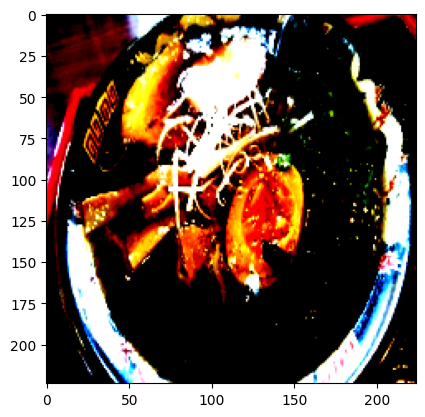

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image batch dimensions: torch.Size([16, 3, 224, 224])
Image label dimensions: torch.Size([16])


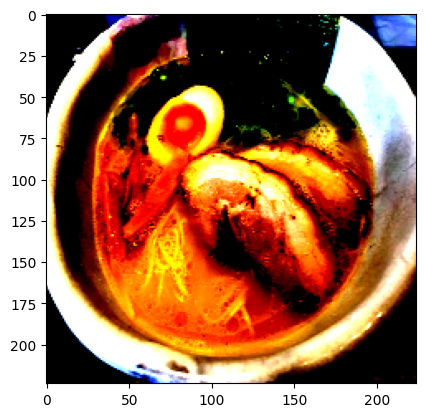

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Checking the dataset
for images, labels in trainloader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

for img,labels in trainloader:
    # load a batch from train data
    break

# this converts it from GPU to CPU and selects first image
img = img.cpu().numpy()[0]
#convert image back to Height,Width,Channels
img = np.transpose(img, (1,2,0))
#show the image
plt.imshow(img)
plt.show()

for images, labels in validloader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

for img_test,labels in validloader:
    # load a batch from train data
    break

# this converts it from GPU to CPU and selects first image
img_test = img_test.cpu().numpy()[0]
#convert image back to Height,Width,Channels
img_test = np.transpose(img_test, (1,2,0))
#show the image
plt.imshow(img_test)
plt.show()

In [35]:
##############################################
# Build your model here!
#
# Practice:
#   Try to implement VGG-16 with pytorch !
##############################################

class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()

        ##############################################################################
        #                          TODO: implement VGG-16.                           #
        ##############################################################################
        self.conv_block = nn.Sequential(
#---------------------------------------------------------------------------------------------------------------------------
            nn.Conv2d(3,  64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),
#---------------------------------------------------------------------------------------------------------------------------
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),
#---------------------------------------------------------------------------------------------------------------------------
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),
#---------------------------------------------------------------------------------------------------------------------------
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),
#---------------------------------------------------------------------------------------------------------------------------
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),
        )
#---------------------------------------------------------------------------------------------------------------------------
        self.feat_classifier = nn.Sequential(
            nn.Linear(7*7*512, 4096),
            nn.Dropout(0,2),
            # nn.Conv1d(4096, 4096, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Linear(4096, 2048),
            # nn.Conv1d(2048, 2048, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Linear(2048, 1024),
            # nn.Conv1d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Linear(1024, 512),
            # nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Linear(512, 256),
            # nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Linear(256, class_num),
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x, 1)
        x = self.feat_classifier(x)
        return x

model = VGG16()
model.to(device)

VGG16(
  (conv_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding

In [36]:
print("device: ",device)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10

model.train()

device:  cuda:0


VGG16(
  (conv_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding

In [37]:
from torchsummary import summary
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [38]:
WEIGHT_PATH = 'Saving_Path/model_weight.pth'
checkpoint = torch.load(WEIGHT_PATH , map_location="cuda:0")
model.load_state_dict(checkpoint)

RuntimeError: Error(s) in loading state_dict for VGG16:
	Missing key(s) in state_dict: "feat_classifier.3.weight", "feat_classifier.3.bias", "feat_classifier.5.weight", "feat_classifier.5.bias", "feat_classifier.7.weight", "feat_classifier.7.bias", "feat_classifier.9.weight", "feat_classifier.9.bias", "feat_classifier.11.weight", "feat_classifier.11.bias". 
	Unexpected key(s) in state_dict: "feat_classifier.2.weight", "feat_classifier.2.bias", "feat_classifier.4.weight", "feat_classifier.4.bias", "feat_classifier.6.weight", "feat_classifier.6.bias", "feat_classifier.8.weight", "feat_classifier.8.bias", "feat_classifier.10.weight", "feat_classifier.10.bias". 

In [39]:
# Training model
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

# Specify the saving weight path
SAVING_PATH = './Saving_Path'

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, epochs+1):# loop over the dataset multiple times

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    print('running epoch: {}'.format(epoch))

    # train the model
    model.train()
    train_correct = 0
    train_total = 0
    for data, target in tqdm(trainloader):
      # move tensors to GPU if CUDA is available
      data, target = data.to(device), target.to(device)
      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optimizer.step()
      # update training loss
      train_loss += loss.item()*data.size(0)
      # update training Accuracy
      train_total += target.size(0)
      _, predicted = torch.max(output.data, 1)
      train_correct += (predicted == target).sum().item()


    # validate the model
    model.eval()
    valid_correct = 0
    valid_total = 0
    for data, target in tqdm(validloader):
        # move tensors to GPU if CUDA is available
        target = target.long()
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)
        # update validation Accuracy
        valid_total += target.size(0)
        _, predicted = torch.max(output.data, 1)
        valid_correct += (predicted == target).sum().item()
    # calculate average losses
    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(validloader.dataset)

    # print training/validation statistics
    print('Training Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(train_loss,(100 * train_correct / train_total)))
    print('Validation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(valid_loss,(100 * valid_correct / valid_total)))

    train_loss_list.append(train_loss)
    train_acc_list.append(100 * train_correct / train_total)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(100 * valid_correct / valid_total)

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), SAVING_PATH+'/model_weight.pth')
        valid_loss_min = valid_loss

print('Finished Training')

running epoch: 1


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Training Loss: 0.435038 	Training Accuracy: 83.041667
Validation Loss: 0.596118 	Validation Accuracy: 78.333333
Validation loss decreased (inf --> 0.596118).  Saving model ...
running epoch: 2


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Training Loss: 0.317262 	Training Accuracy: 87.625000
Validation Loss: 0.796437 	Validation Accuracy: 78.000000
running epoch: 3


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Training Loss: 0.296407 	Training Accuracy: 88.375000
Validation Loss: 0.727206 	Validation Accuracy: 76.833333
running epoch: 4


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Training Loss: 0.238142 	Training Accuracy: 91.125000
Validation Loss: 0.953119 	Validation Accuracy: 77.333333
running epoch: 5


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Training Loss: 0.229914 	Training Accuracy: 90.958333
Validation Loss: 0.913089 	Validation Accuracy: 76.500000
running epoch: 6


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Training Loss: 0.180000 	Training Accuracy: 93.541667
Validation Loss: 0.859431 	Validation Accuracy: 78.333333
running epoch: 7


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Training Loss: 0.159982 	Training Accuracy: 94.416667
Validation Loss: 0.905547 	Validation Accuracy: 74.333333
running epoch: 8


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Training Loss: 0.179090 	Training Accuracy: 93.666667
Validation Loss: 0.902735 	Validation Accuracy: 77.166667
running epoch: 9


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Training Loss: 0.149155 	Training Accuracy: 95.416667
Validation Loss: 0.814817 	Validation Accuracy: 75.333333
running epoch: 10


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Training Loss: 0.148908 	Training Accuracy: 95.000000
Validation Loss: 1.168475 	Validation Accuracy: 73.000000
Finished Training


In [42]:
def plt_loss_acc(list_to_draw,name):
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    if name=="train_loss":
      ax1.set_title('Train Loss')
      ax1.plot(list_to_draw)
    elif name=="train_acc":
      ax1.set_title('Train Accuracy')
      ax1.plot(list_to_draw)
    elif name=="valid_loss":
      ax1.set_title('Valid Loss')
      ax1.plot(list_to_draw)
    elif name=="valid_acc":
      ax1.set_title('Valid Accuracy')
      ax1.plot(list_to_draw)

    ax1.set_xlabel('epoch')
    plt.show()

def plt_loss_acc_all():
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('All acc and loss')

    ax1.plot(train_loss_list)
    ax1.plot(train_acc_list)
    ax1.plot(valid_loss_list)
    ax1.plot(valid_acc_list)

    ax1.legend(['train_loss', 'train_acc', 'valid_loss', 'valid_acc'], loc='upper left')
    ax1.set_xlabel('epoch')
    plt.show()

def plt_acc_all():
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('All acc')

    ax1.plot(train_acc_list)
    ax1.plot(valid_acc_list)

    ax1.legend(['train_acc', 'valid_acc'], loc='upper left')
    ax1.set_xlabel('epoch')
    plt.show()

def plt_loss_all():
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('All loss')

    ax1.plot(train_loss_list)
    ax1.plot(valid_loss_list)

    ax1.legend(['train_loss', 'valid_loss'], loc='upper left')
    ax1.set_xlabel('epoch')
    plt.show()

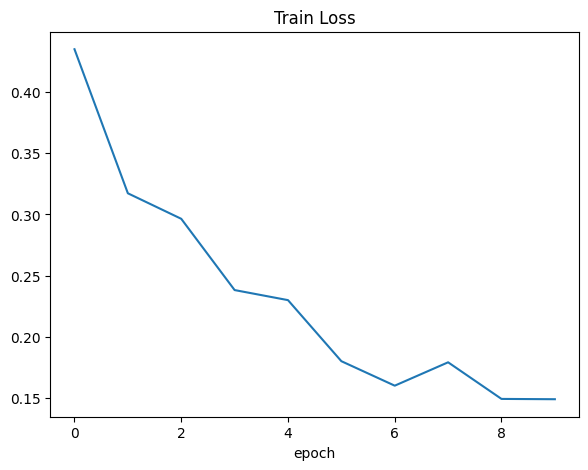

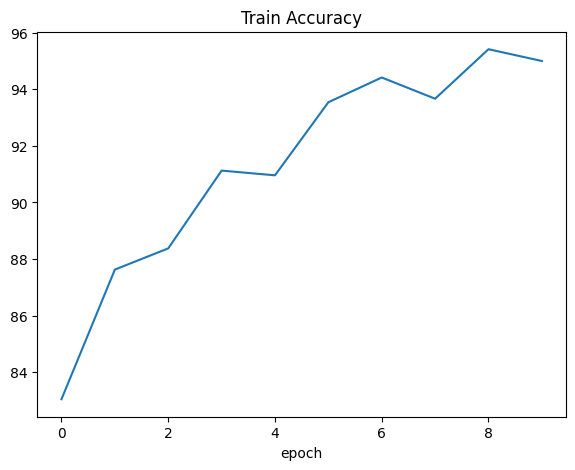

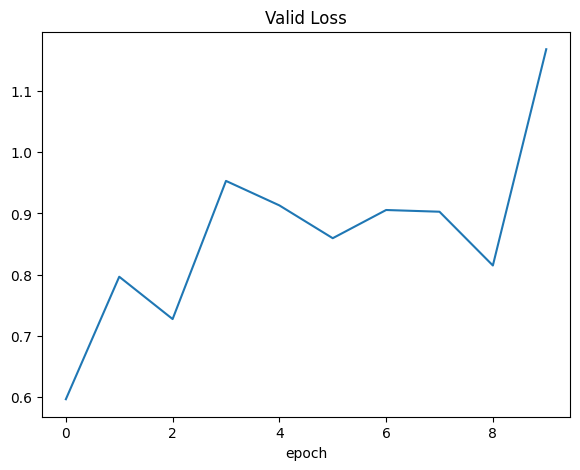

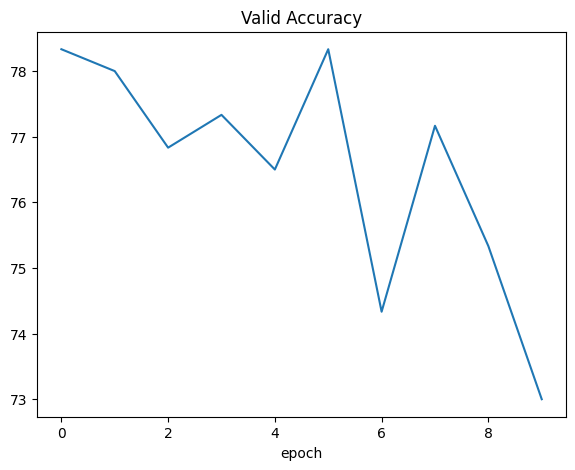

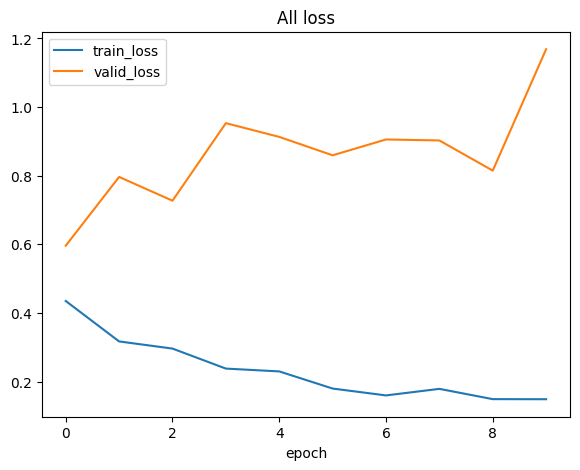

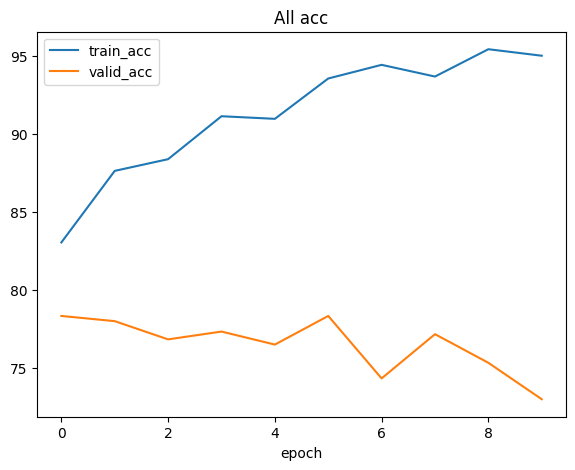

In [43]:
plt_loss_acc(train_loss_list, "train_loss")
plt_loss_acc(train_acc_list, "train_acc")
plt_loss_acc(valid_loss_list, "valid_loss")
plt_loss_acc(valid_acc_list, "valid_acc")
plt_loss_all()
plt_acc_all()

In [44]:
print(predicted[0].item())
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as data_utils
TESTDATA_PATH = './noodles_dataset_3k/test/unknown'
for data in os.walk(TESTDATA_PATH):
  test_data=data[2]
test_transform = transforms.Compose([

    transforms.Resize((224, 224)),

    transforms.ToTensor(),

    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225])
    ])
class Custom_testset(Dataset):
    def __init__(self,testData,transform=None):
        # --------------------------------------------
        # Initialize paths, transforms, and so on
        # --------------------------------------------
        self.images = testData
        #self.label = trainLabel
        self.transform = transform

    def __getitem__(self, index):
        # --------------------------------------------
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        # --------------------------------------------
        imgpath = self.images[index]
        img = Image.open(imgpath).convert('RGB')

        if self.transform:
          img = self.transform(img)

        return img

    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        return len(self.images)

def trueclass(num):
  if num==0:
    return 0
  elif num==1:
    return 1
  elif num==2:
    return 2

imgpath=[]
prediction=[]
for photo in test_data:
  path_img = os.path.join(TESTDATA_PATH,photo)
  imgpath.append(path_img)
# print('id = ',test_data)
test_set = Custom_testset(imgpath,test_transform)
testloader = DataLoader(test_set, batch_size=1 , shuffle=False, num_workers = 0)
for images in testloader:
    print('Image batch dimensions:', images.shape)
    break

#images = np.transpose(images, (1,2,0))
for images in testloader:
  #print('image = ',images)
  images=images.to(device)
  output = model(images)
  predicted = torch.argmax(output,dim=1)
  #print('Image predicted label = :', predicted.item())
  prediction=np.append(prediction,trueclass(predicted.item()))

2
Image batch dimensions: torch.Size([1, 3, 224, 224])


In [45]:
prediction_lst=prediction.tolist()
for i in range(len(prediction_lst)):
  prediction_lst[i] = int(prediction_lst[i])
test_data_num=[]
for i in range(len(test_data)):
  test_data_num.append(i)

example={'ID':test_data_num,
      'Target':prediction_lst}
df = pd.DataFrame(example)
print(df)

df.to_csv('./result.csv',index=False)

      ID  Target
0      0       2
1      1       2
2      2       0
3      3       2
4      4       2
..   ...     ...
995  995       0
996  996       0
997  997       2
998  998       2
999  999       0

[1000 rows x 2 columns]
